# NPS vs FCFS Significance Analysis

This notebook quickly identifies experimental conditions where NPS-based prioritization shows statistically significant advantages over FCFS.

## Instructions:
1. Set the `EXPERIMENT_FOLDER` path below
2. Run all cells
3. Review the summary tables and plots for significant differences


In [61]:
# ================================
# CONFIGURATION - CHANGE THIS PATH
# ================================

#EXPERIMENT_FOLDER = "../experiments/gridsearch_known_topic"  # Change this to your experiment folder
EXPERIMENT_FOLDER = "../experiments/gamma_test"
EXPERIMENT_FOLDER = "../experiments/contrast_experiment"

# ================================


In [62]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


In [63]:
def load_experiment_data(experiment_folder):
    """
    Load all experimental data from the specified folder.
    Returns combined dataframe with all experimental results.
    """
    base_path = Path(experiment_folder)
    
    # Load design table to get experimental parameters
    design_path = base_path / "design_table.csv"
    if not design_path.exists():
        raise FileNotFoundError(f"Design table not found at {design_path}")
    
    design_table = pd.read_csv(design_path)
    print(f"Design table loaded: {len(design_table)} experiments")
    
    # Load all log files
    all_logs = []
    missing_files = []
    
    for idx, row in design_table.iterrows():
        if row['Done'] == 1:  # Only load completed experiments
            run_folder = base_path / str(idx)
            log_file = run_folder / f"{idx}_log.csv"
            
            if log_file.exists():
                try:
                    log_data = pd.read_csv(log_file)
                    # Add experimental parameters to each row
                    for col in design_table.columns:
                        if col not in ['Done', 'Started_at', 'Finished_at', 'Simulation_duration_min']:
                            log_data[f'exp_{col}'] = row[col]
                    log_data['experiment_id'] = idx
                    all_logs.append(log_data)
                except Exception as e:
                    print(f"Error loading {log_file}: {e}")
                    missing_files.append(str(log_file))
            else:
                missing_files.append(str(log_file))
    
    if missing_files:
        print(f"Warning: {len(missing_files)} files could not be loaded")
    
    if not all_logs:
        raise ValueError("No log files could be loaded successfully")
    
    combined_data = pd.concat(all_logs, ignore_index=True)
    print(f"Loaded {len(all_logs)} experiment files with {len(combined_data)} total records")
    
    return combined_data, design_table

# Load the data
print(f"Loading data from: {EXPERIMENT_FOLDER}")
df, design_table = load_experiment_data(EXPERIMENT_FOLDER)
print(f"Data loaded successfully! Shape: {df.shape}")


Loading data from: ../experiments/contrast_experiment
Design table loaded: 20 experiments
Loaded 20 experiment files with 33958 total records
Data loaded successfully! Shape: (33958, 100)


In [64]:
# Data preprocessing and filtering
print("Data preprocessing...")

# Filter to main period only (exclude burn-in)
df_main = df[df['burn_in_period'] == False].copy()
print(f"Main period data: {len(df_main)} records")

# Filter to closed cases only (cases with simulated NPS)
df_closed = df_main[df_main['case_status'] == 'closed'].copy()
print(f"Closed cases: {len(df_closed)} records")

# Get unique cases (remove duplicate activities per case)
df_cases = df_closed.drop_duplicates(subset=['case_id', 'experiment_id']).copy()
print(f"Unique closed cases: {len(df_cases)} records")

# Display available experimental factors
exp_columns = [col for col in df_cases.columns if col.startswith('exp_')]
print(f"\nExperimental factors: {exp_columns}")

# Show priority scheme distribution
print(f"\nPriority schemes: {df_cases['exp_F_priority_scheme'].value_counts().to_dict()}")

# Check for NPS and FCFS data
if 'NPS' not in df_cases['exp_F_priority_scheme'].values:
    print("WARNING: No NPS data found!")
if 'FCFS' not in df_cases['exp_F_priority_scheme'].values:
    print("WARNING: No FCFS data found!")


Data preprocessing...
Main period data: 16486 records
Closed cases: 16486 records
Unique closed cases: 3529 records

Experimental factors: ['exp_F_priority_scheme', 'exp_F_number_of_agents', 'exp_F_hard_ceiling', 'exp_F_fit_on_burn_in', 'exp_F_throughput_model', 'exp_F_throughput_model_penalty', 'exp_F_nps_model', 'exp_F_nps_model_penalty', 'exp_F_ceiling_value', 'exp_F_burn_in', 'exp_F_days', 'exp_F_NPS_dist_bias', 'exp_F_tNPS_wtime_effect_bias', 'exp_startdate', 'exp_repetition', 'exp_closed_avg_simulated_NPS', 'exp_closed_avg_simulated_throughput_time', 'exp_closed_avg_predicted_NPS', 'exp_closed_avg_predicted_throughput_time', 'exp_closed_avg_predicted_NPS_priority', 'exp_closed_avg_initial_delay', 'exp_closed_avg_activity_start_delay', 'exp_closed_avg_duration_delayed', 'exp_all_avg_simulated_NPS', 'exp_all_avg_simulated_throughput_time', 'exp_all_avg_predicted_NPS', 'exp_all_avg_predicted_throughput_time', 'exp_all_avg_predicted_NPS_priority', 'exp_all_avg_initial_delay', 'exp_al

In [65]:
# Data structure diagnostics
print("=== DATA STRUCTURE DIAGNOSTICS ===")

# Check key experimental factors
key_factors = ['exp_F_number_of_agents', 'exp_F_burn_in', 'exp_F_days', 'exp_F_NPS_dist_bias', 'exp_F_tNPS_wtime_effect_bias']
for factor in key_factors:
    if factor in df_cases.columns:
        unique_vals = df_cases[factor].unique()
        print(f"{factor}: {unique_vals}")

# Check repetition structure
print(f"\nRepetition structure:")
print(f"exp_repetition values: {sorted(df_cases['exp_repetition'].unique())}")

# Check data balance by priority scheme
print(f"\nData balance by priority scheme and key factors:")
balance_check = df_cases.groupby(['exp_F_priority_scheme', 'exp_F_tNPS_wtime_effect_bias']).size().reset_index(name='count')
print(balance_check)

print("\n" + "="*50)


=== DATA STRUCTURE DIAGNOSTICS ===
exp_F_number_of_agents: [3]
exp_F_burn_in: [100]
exp_F_days: [350]
exp_F_NPS_dist_bias: [0.]
exp_F_tNPS_wtime_effect_bias: [5.]

Repetition structure:
exp_repetition values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Data balance by priority scheme and key factors:
  exp_F_priority_scheme  exp_F_tNPS_wtime_effect_bias  count
0                  FCFS                           5.0   1756
1                   NPS                           5.0   1773



In [66]:
def calculate_summary_statistics(df_cases):
    """
    Calculate summary statistics for each experimental condition.
    """
    # Group by core experimental factors and priority scheme
    core_exp_factors = [
        'exp_F_priority_scheme', 'exp_F_number_of_agents', 'exp_F_hard_ceiling', 'exp_F_ceiling_value', 
        'exp_F_burn_in', 'exp_F_days', 'exp_F_NPS_dist_bias', 'exp_F_tNPS_wtime_effect_bias',
        'exp_startdate'
    ]
    
    # Only use factors that actually exist in the data
    group_cols = [col for col in core_exp_factors if col in df_cases.columns]
    
    summary_stats = df_cases.groupby(group_cols).agg({
        'simulated_NPS': ['count', 'mean', 'std', 'median'],
        'simulated_throughput_time': ['mean', 'std', 'median'],
        'case_id': 'count'
    }).round(4)
    
    # Flatten column names
    summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns]
    summary_stats = summary_stats.reset_index()
    
    return summary_stats

# Calculate summary statistics
summary_stats = calculate_summary_statistics(df_cases)
print(f"Summary statistics calculated for {len(summary_stats)} conditions")
print(f"\nSample of summary statistics:")
print(summary_stats.head())


Summary statistics calculated for 2 conditions

Sample of summary statistics:
  exp_F_priority_scheme  exp_F_number_of_agents exp_F_hard_ceiling  \
0                  FCFS                       3               NONE   
1                   NPS                       3               NONE   

   exp_F_ceiling_value  exp_F_burn_in  exp_F_days  exp_F_NPS_dist_bias  \
0                  2.5            100         350                  0.0   
1                  2.5            100         350                  0.0   

   exp_F_tNPS_wtime_effect_bias exp_startdate  simulated_NPS_count  \
0                           5.0    2018-07-01                 1756   
1                           5.0    2018-07-01                 1773   

   simulated_NPS_mean  simulated_NPS_std  simulated_NPS_median  \
0              4.5211             2.6096                4.2732   
1              4.5733             2.6206                4.3429   

   simulated_throughput_time_mean  simulated_throughput_time_std  \
0         

In [67]:
def perform_significance_tests(df_cases):
    """
    Perform statistical significance tests comparing NPS vs FCFS across all conditions.
    """
    results = []
    
    # Get core experimental design factors (NOT the summary statistics columns)
    core_exp_factors = [
        'exp_F_number_of_agents', 'exp_F_hard_ceiling', 'exp_F_ceiling_value', 
        'exp_F_burn_in', 'exp_F_days', 'exp_F_NPS_dist_bias', 'exp_F_tNPS_wtime_effect_bias',
        'exp_startdate'
    ]
    
    # Only use factors that actually exist in the data
    condition_cols = [col for col in core_exp_factors if col in df_cases.columns]
    
    print(f"Grouping by experimental factors: {condition_cols}")
    
    # Group by experimental conditions (excluding repetition and priority scheme)
    for condition_values, group in df_cases.groupby(condition_cols):
        # Get NPS and FCFS data for this condition
        nps_data = group[group['exp_F_priority_scheme'] == 'NPS']['simulated_NPS']
        fcfs_data = group[group['exp_F_priority_scheme'] == 'FCFS']['simulated_NPS']
        
        print(f"Condition: {condition_values} - NPS: {len(nps_data)} cases, FCFS: {len(fcfs_data)} cases")
        
        if len(nps_data) > 5 and len(fcfs_data) > 5:  # Require at least 5 cases for meaningful comparison
            # Perform t-test
            try:
                t_stat, t_pval = ttest_ind(nps_data, fcfs_data)
                
                # Perform Mann-Whitney U test (non-parametric)
                u_stat, u_pval = mannwhitneyu(nps_data, fcfs_data, alternative='two-sided')
                
                # Calculate effect size (Cohen's d)
                pooled_std = np.sqrt(((len(nps_data) - 1) * nps_data.std()**2 + 
                                     (len(fcfs_data) - 1) * fcfs_data.std()**2) / 
                                    (len(nps_data) + len(fcfs_data) - 2))
                cohens_d = (nps_data.mean() - fcfs_data.mean()) / pooled_std if pooled_std > 0 else 0
                
                # Store results
                result = {
                    'nps_mean': nps_data.mean(),
                    'nps_std': nps_data.std(),
                    'nps_count': len(nps_data),
                    'fcfs_mean': fcfs_data.mean(),
                    'fcfs_std': fcfs_data.std(),
                    'fcfs_count': len(fcfs_data),
                    'mean_difference': nps_data.mean() - fcfs_data.mean(),
                    't_statistic': t_stat,
                    't_pvalue': t_pval,
                    'u_statistic': u_stat,
                    'u_pvalue': u_pval,
                    'cohens_d': cohens_d,
                    'significant_005': t_pval < 0.05,
                    'significant_001': t_pval < 0.01,
                    'effect_size_interpretation': 'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'
                }
                
                # Add condition information
                if isinstance(condition_values, tuple):
                    for i, col in enumerate(condition_cols):
                        result[col] = condition_values[i]
                else:
                    result[condition_cols[0]] = condition_values
                
                results.append(result)
                
                print(f"  -> Test performed: p={t_pval:.6f}, Cohen's d={cohens_d:.3f}")
                
            except Exception as e:
                print(f"Error in statistical test for condition {condition_values}: {e}")
        else:
            print(f"  -> Skipped: insufficient data for comparison")
    
    return pd.DataFrame(results)

# Perform significance tests
print("Performing significance tests...")
significance_results = perform_significance_tests(df_cases)
print(f"Significance tests completed for {len(significance_results)} conditions")


Performing significance tests...
Grouping by experimental factors: ['exp_F_number_of_agents', 'exp_F_hard_ceiling', 'exp_F_ceiling_value', 'exp_F_burn_in', 'exp_F_days', 'exp_F_NPS_dist_bias', 'exp_F_tNPS_wtime_effect_bias', 'exp_startdate']
Condition: (3, 'NONE', 2.5, 100, 350, 0.0, 5.0, '2018-07-01') - NPS: 1773 cases, FCFS: 1756 cases
  -> Test performed: p=0.552815, Cohen's d=0.020
Significance tests completed for 1 conditions


In [68]:
# Display significant results
print("=" * 80)
print("SIGNIFICANT DIFFERENCES (p < 0.05)")
print("=" * 80)

if len(significance_results) > 0:
    significant_results = significance_results[significance_results['significant_005'] == True].copy()
    
    if len(significant_results) > 0:
        # Sort by effect size (absolute value)
        significant_results = significant_results.reindex(
            significant_results['cohens_d'].abs().sort_values(ascending=False).index
        )
        
        print(f"Found {len(significant_results)} conditions with significant differences!\n")
        
        # Display key columns
        display_cols = [col for col in significant_results.columns if col.startswith('exp_')] + [
            'nps_mean', 'fcfs_mean', 'mean_difference', 't_pvalue', 'cohens_d', 'effect_size_interpretation'
        ]
        
        display_results = significant_results[display_cols].copy()
        
        # Round numerical columns
        numerical_cols = ['nps_mean', 'fcfs_mean', 'mean_difference', 't_pvalue', 'cohens_d']
        for col in numerical_cols:
            if col in display_results.columns:
                display_results[col] = display_results[col].round(4)
        
        print(display_results.to_string(index=False))
        
        # Highlight best conditions
        print("\n" + "=" * 50)
        print("TOP 3 CONDITIONS (Largest Effect Sizes):")
        print("=" * 50)
        top_3 = display_results.head(3)
        for idx, row in top_3.iterrows():
            print(f"\nCondition {idx + 1}:")
            exp_params = {col.replace('exp_', ''): row[col] for col in display_cols if col.startswith('exp_')}
            for param, value in exp_params.items():
                print(f"  {param}: {value}")
            print(f"  NPS Mean: {row['nps_mean']:.4f} vs FCFS Mean: {row['fcfs_mean']:.4f}")
            print(f"  Difference: {row['mean_difference']:.4f}")
            print(f"  p-value: {row['t_pvalue']:.6f}")
            print(f"  Effect Size (Cohen's d): {row['cohens_d']:.4f} ({row['effect_size_interpretation']})")
    
    else:
        print("No significant differences found at p < 0.05 level.")
        print("\nClosest to significance:")
        closest = significance_results.nsmallest(5, 't_pvalue')
        display_cols = [col for col in closest.columns if col.startswith('exp_')] + [
            'nps_mean', 'fcfs_mean', 'mean_difference', 't_pvalue', 'cohens_d'
        ]
        print(closest[display_cols].round(4).to_string(index=False))
else:
    print("No significance test results available.")


SIGNIFICANT DIFFERENCES (p < 0.05)
No significant differences found at p < 0.05 level.

Closest to significance:
 exp_F_number_of_agents exp_F_hard_ceiling  exp_F_ceiling_value  exp_F_burn_in  exp_F_days  exp_F_NPS_dist_bias  exp_F_tNPS_wtime_effect_bias exp_startdate  nps_mean  fcfs_mean  mean_difference  t_pvalue  cohens_d
                      3               NONE                  2.5            100         350                  0.0                           5.0    2018-07-01    4.5733     4.5211           0.0523    0.5528      0.02


Creating visualizations...


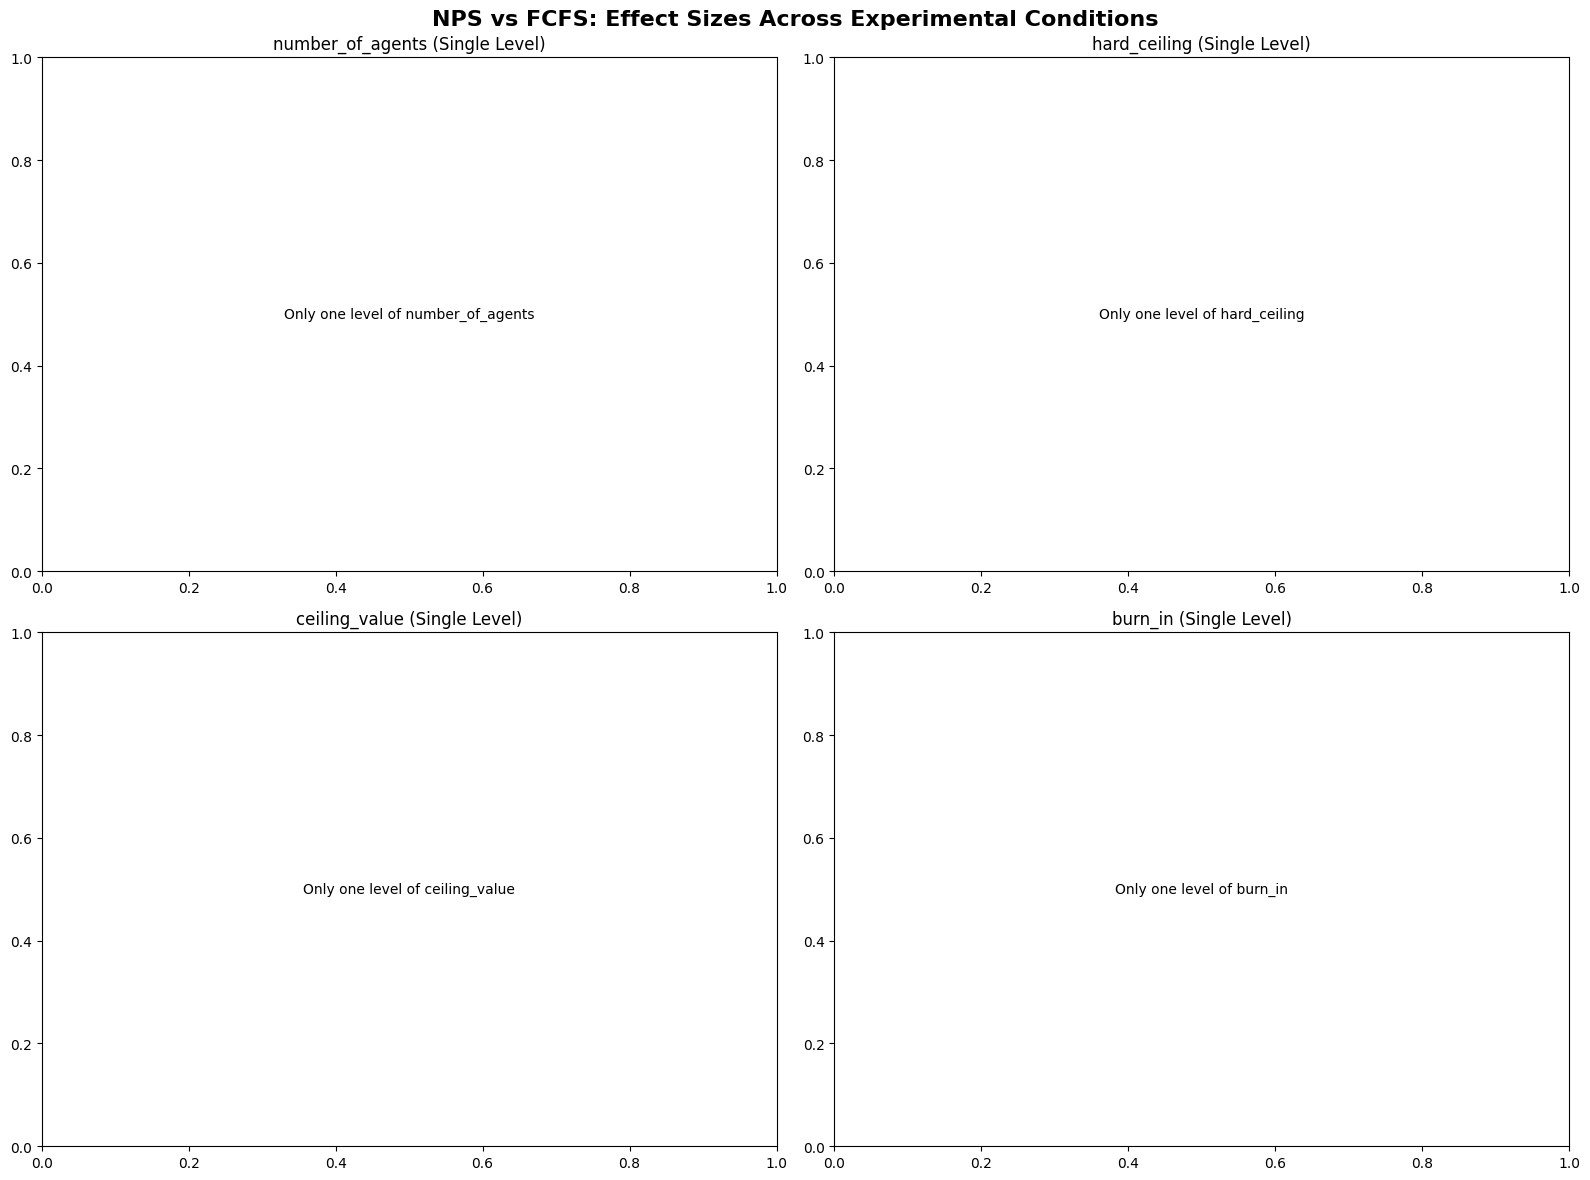

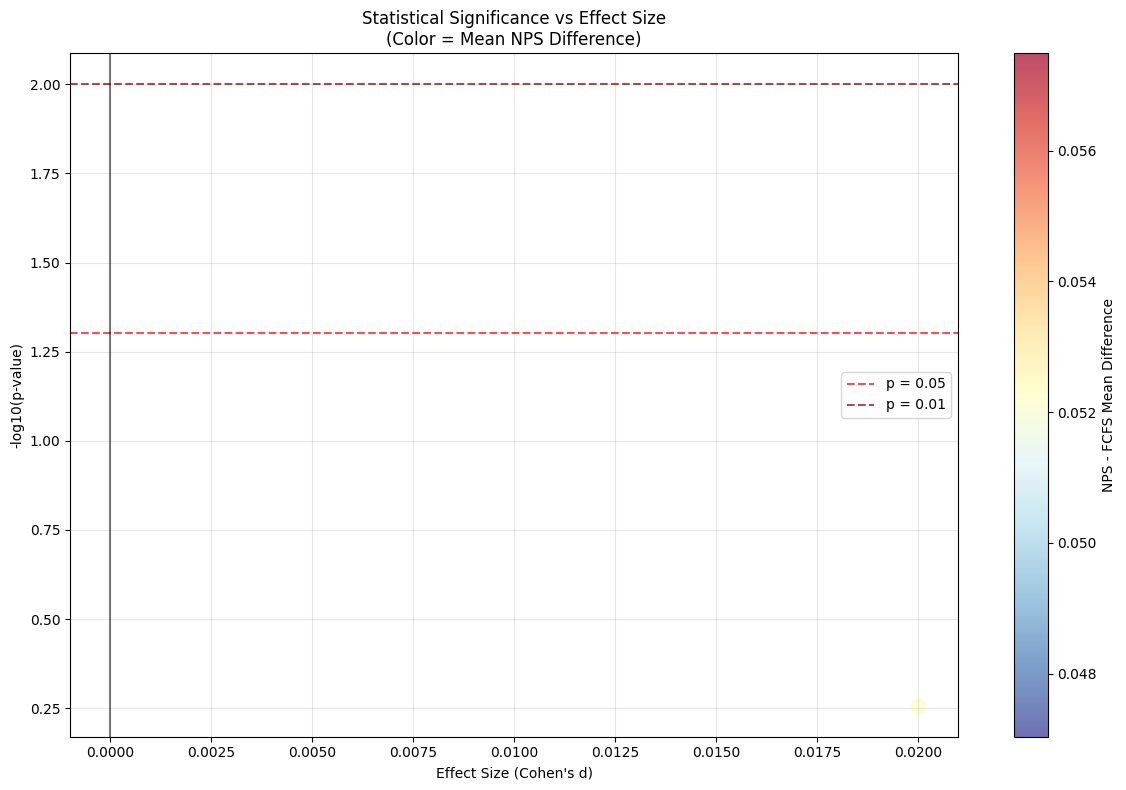

In [69]:
# Create visualization of results
print("Creating visualizations...")

if len(significance_results) > 0:
    # 1. Effect sizes by experimental factors
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('NPS vs FCFS: Effect Sizes Across Experimental Conditions', fontsize=16, fontweight='bold')
    
    # Check which experimental factors exist
    factor_cols = [col for col in significance_results.columns if col.startswith('exp_F_')]
    
    plot_idx = 0
    for factor_col in factor_cols[:4]:  # Plot up to 4 factors
        ax = axes[plot_idx // 2, plot_idx % 2]
        
        # Create boxplot of effect sizes by factor
        factor_name = factor_col.replace('exp_F_', '')
        
        if len(significance_results[factor_col].unique()) > 1:
            sns.boxplot(data=significance_results, x=factor_col, y='cohens_d', ax=ax)
            ax.set_title(f'Effect Size by {factor_name}')
            ax.set_xlabel(factor_name)
            ax.set_ylabel("Cohen's d (Effect Size)")
            ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
            
            # Add significance markers
            for i, (idx, row) in enumerate(significance_results.iterrows()):
                if row['significant_005']:
                    ax.scatter(i % len(significance_results[factor_col].unique()), row['cohens_d'], 
                              color='red', s=100, marker='*', zorder=10)
        else:
            ax.text(0.5, 0.5, f'Only one level of {factor_name}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{factor_name} (Single Level)')
        
        plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, 4):
        axes[i // 2, i % 2].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 2. P-values vs Effect Sizes
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(significance_results['cohens_d'], -np.log10(significance_results['t_pvalue']), 
                         c=significance_results['mean_difference'], 
                         s=100, alpha=0.7, cmap='RdYlBu_r')
    
    plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='p = 0.05')
    plt.axhline(y=-np.log10(0.01), color='darkred', linestyle='--', alpha=0.7, label='p = 0.01')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    
    plt.xlabel("Effect Size (Cohen's d)")
    plt.ylabel("-log10(p-value)")
    plt.title("Statistical Significance vs Effect Size\n(Color = Mean NPS Difference)")
    plt.colorbar(scatter, label='NPS - FCFS Mean Difference')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Annotate significant points
    significant_mask = significance_results['significant_005']
    for idx, row in significance_results[significant_mask].iterrows():
        plt.annotate(f'p={row["t_pvalue"]:.3f}', 
                    (row['cohens_d'], -np.log10(row['t_pvalue'])),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()

else:
    print("No results to visualize.")


In [70]:
# Create distribution comparison plots for significant conditions
if len(significance_results) > 0:
    significant_conditions = significance_results[significance_results['significant_005'] == True]
    
    if len(significant_conditions) > 0:
        print(f"Creating distribution plots for {min(3, len(significant_conditions))} most significant conditions...")
        
        # Get top 3 conditions by effect size
        top_conditions = significant_conditions.nlargest(3, 'cohens_d')
        
        fig, axes = plt.subplots(len(top_conditions), 1, figsize=(12, 4 * len(top_conditions)))
        if len(top_conditions) == 1:
            axes = [axes]
        
        for i, (_, condition) in enumerate(top_conditions.iterrows()):
            ax = axes[i]
            
            # Filter data for this condition
            condition_filter = pd.Series([True] * len(df_cases))
            condition_desc = []
            
            for col in df_cases.columns:
                if col.startswith('exp_') and col in condition.index and col != 'exp_F_priority_scheme':
                    condition_filter &= (df_cases[col] == condition[col])
                    condition_desc.append(f"{col.replace('exp_F_', '')}: {condition[col]}")
            
            condition_data = df_cases[condition_filter]
            
            # Plot distributions
            nps_values = condition_data[condition_data['exp_F_priority_scheme'] == 'NPS']['simulated_NPS']
            fcfs_values = condition_data[condition_data['exp_F_priority_scheme'] == 'FCFS']['simulated_NPS']
            
            if len(nps_values) > 0 and len(fcfs_values) > 0:
                ax.hist(fcfs_values, bins=30, alpha=0.7, label=f'FCFS (n={len(fcfs_values)}, μ={fcfs_values.mean():.2f})', 
                       color='lightcoral', density=True)
                ax.hist(nps_values, bins=30, alpha=0.7, label=f'NPS (n={len(nps_values)}, μ={nps_values.mean():.2f})', 
                       color='skyblue', density=True)
                
                ax.axvline(fcfs_values.mean(), color='red', linestyle='--', alpha=0.8, label='FCFS Mean')
                ax.axvline(nps_values.mean(), color='blue', linestyle='--', alpha=0.8, label='NPS Mean')
                
                ax.set_xlabel('Simulated NPS Score')
                ax.set_ylabel('Density')
                ax.set_title(f'Condition {i+1}: {", ".join(condition_desc)}\n'
                           f'p-value: {condition["t_pvalue"]:.6f}, Effect Size: {condition["cohens_d"]:.3f}')
                ax.legend()
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    else:
        print("No significant conditions to plot distributions for.")
else:
    print("No results available for plotting.")


No significant conditions to plot distributions for.


In [71]:
# Summary report
print("=" * 80)
print("FINAL SUMMARY REPORT")
print("=" * 80)

if len(significance_results) > 0:
    total_conditions = len(significance_results)
    significant_05 = len(significance_results[significance_results['significant_005'] == True])
    significant_01 = len(significance_results[significance_results['significant_001'] == True])
    
    print(f"Total experimental conditions tested: {total_conditions}")
    print(f"Significant at p < 0.05: {significant_05} ({significant_05/total_conditions*100:.1f}%)")
    print(f"Significant at p < 0.01: {significant_01} ({significant_01/total_conditions*100:.1f}%)")
    
    if significant_05 > 0:
        print(f"\nEffect size distribution:")
        sig_results = significance_results[significance_results['significant_005'] == True]
        effect_sizes = sig_results['effect_size_interpretation'].value_counts()
        for effect, count in effect_sizes.items():
            print(f"  {effect.capitalize()} effect: {count} conditions")
        
        print(f"\nMean difference range: {sig_results['mean_difference'].min():.3f} to {sig_results['mean_difference'].max():.3f}")
        print(f"Best NPS advantage: {sig_results['mean_difference'].max():.3f} NPS points")
        
        # Identify key factors for significant differences
        print(f"\nFactors associated with significant differences:")
        factor_cols = [col for col in sig_results.columns if col.startswith('exp_F_')]
        for col in factor_cols:
            if len(sig_results[col].unique()) > 1:
                factor_summary = sig_results.groupby(col)['mean_difference'].agg(['count', 'mean']).round(3)
                print(f"\n  {col.replace('exp_F_', '')}:")
                for value, stats in factor_summary.iterrows():
                    print(f"    {value}: {stats['count']} conditions, avg difference = {stats['mean']:.3f}")
    
    print(f"\n" + "=" * 50)
    print("RECOMMENDATIONS:")
    print("=" * 50)
    
    if significant_05 > 0:
        best_condition = significance_results.loc[significance_results['cohens_d'].abs().idxmax()]
        print(f"\n✅ SIGNIFICANT DIFFERENCES FOUND!")
        print(f"\nBest performing condition:")
        exp_params = {col.replace('exp_F_', ''): best_condition[col] 
                     for col in best_condition.index if col.startswith('exp_F_') and col != 'exp_F_priority_scheme'}
        for param, value in exp_params.items():
            print(f"  {param}: {value}")
        print(f"\nNPS shows {best_condition['mean_difference']:.3f} point advantage over FCFS")
        print(f"Effect size: {best_condition['cohens_d']:.3f} ({best_condition['effect_size_interpretation']})")
        print(f"Statistical significance: p = {best_condition['t_pvalue']:.6f}")
    else:
        print(f"\n❌ NO SIGNIFICANT DIFFERENCES FOUND")
        print(f"\nRecommendations:")
        print(f"1. Consider more extreme parameter values")
        print(f"2. Increase sample sizes (more repetitions)")
        print(f"3. Check if system stress is sufficient (reduce agents)")
        print(f"4. Increase F_tNPS_wtime_effect_bias values")

else:
    print("No statistical tests were performed. Check data availability.")

print(f"\n" + "=" * 80)
print(f"Analysis complete! Experiment folder: {EXPERIMENT_FOLDER}")
print("=" * 80)


FINAL SUMMARY REPORT
Total experimental conditions tested: 1
Significant at p < 0.05: 0 (0.0%)
Significant at p < 0.01: 0 (0.0%)

RECOMMENDATIONS:

❌ NO SIGNIFICANT DIFFERENCES FOUND

Recommendations:
1. Consider more extreme parameter values
2. Increase sample sizes (more repetitions)
3. Check if system stress is sufficient (reduce agents)
4. Increase F_tNPS_wtime_effect_bias values

Analysis complete! Experiment folder: ../experiments/contrast_experiment
